In [1]:
import numpy as np
import tqdm 
import matplotlib.pyplot as plt
from astropy.constants import G
import matplotlib as mpl
import sys
from scipy import interpolate
from matplotlib import colors 

sys.path.append('../my_funcs/')
from pipeline_main import pipeline, dist

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1192.17it/s]


Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 8196.25it/s]


Disk size: 17.9 au


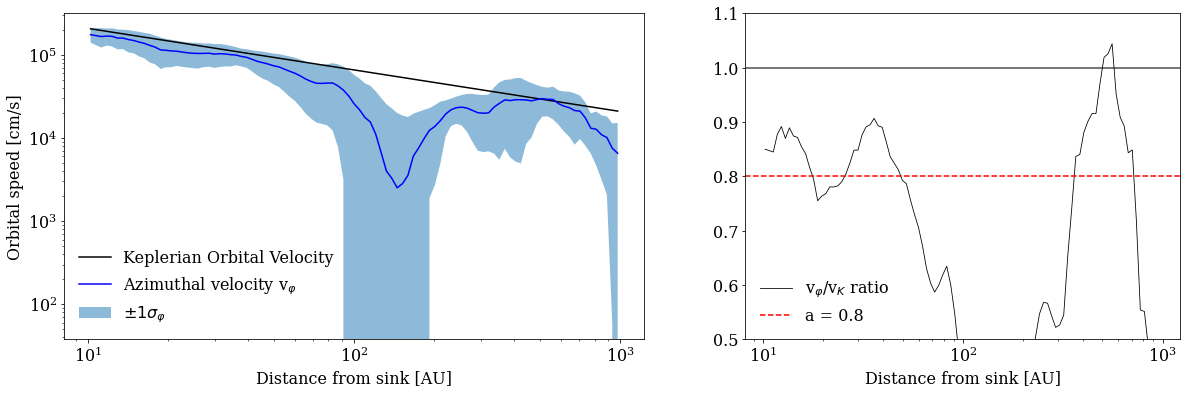

In [2]:
data = pipeline(snap = 357, run = 'my_core_13lacc', sink_id=13)
data.recalc_L(verbose = 1); 
data.calc_disksize()

In [3]:
data.calc_trans_xyz()

Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 4799.47it/s]


# Initially calculating the all the differnt component of anguluar momentum loss in the radial direction

### Mechanical (Raynolds stress):
#### $$F_r^{Reynolds}(R)=-\int_{-h/2}^{h/2}dz \int_0^{2\pi}R^2d\phi \rho v_\phi(R,\phi,z)v_r(R,\phi,z)$$

### Magnetically induced transport (Maxwell stress)
#### $$F_r^{Maxwell}(R)=\int_{-h/2}^{h/2}dz \int_0^{2\pi}R^2d\phi \frac{B_\phi(R,\phi,z)B_r(R,\phi,z)}{4\pi}$$

### Transport associated with the gravitational potential $\nabla\Phi^2$ (transport through spiral arms and similar nonaxisymmetric structures)
#### $$F_r^{Grav.}(R)=-\int_{-h/2}^{h/2}dz \int_0^{2\pi}R^2d\phi \frac{(\nabla\Phi)_\phi(R,\phi,z)(\nabla\Phi)_r(R,\phi,z)}{4\pi G}$$

### The definitions are redefined from Küffmeier et al. 2017 so angular momentum **moving out the side is a negative energy denisty** and angular momentum **adding to the disk is positive**.

In [4]:
tick_labels = ['$\pi$/3','2$\pi$/3','$\pi$', '4$\pi$/3', '5$\pi$/3', '2$\pi$']
tick_values = [np.pi/3, 2*np.pi/3, np.pi, np.pi/3 + np.pi, 2*np.pi/3 + np.pi, 2*np.pi]

# Sanity check
### - Plot $v_r(\phi)$ for sanity check

In [5]:
radius = 90
height = radius 
Nh = 100
N_phi = 200
G_cgs = G.to('cm**3 / (g * s**2)').value
radius /= data.au_length; height /= data.au_length
selection_radius = np.sqrt(radius**2 + height**2) * 2 
shell_Δ = 1; shell_Δ /= data.au_length

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

extracted_values =  {key: [] for key in range(7)} # So far this is only for densities and velocities

for p in tqdm.tqdm(sorted_patches):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = (p.cyl_R > radius - shell_Δ) & (p.cyl_R <  radius + shell_Δ)
    #p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
    #p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
    #p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
    #p.Br = np.sum(p.B * p.e_r, axis = 0)
    #p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
    p.vr = np.sum(p.vrel * p.e_r, axis = 0)
    #p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
    #p.gradφ_r = np.sum(p.gradφ * p.e_r, axis = 0)
    
    
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 
    
    #z_coor = p.cyl_z[to_extract].T 
    φ_coor = p.φ[to_extract].T
    vel_r = p.vr[to_extract].T
    #B_φr =  p.Br[to_extract].T * p.Bφ[to_extract].T
    mass_val = p.m[to_extract].T 
    #gradφ_φr = p.gradφ_r[to_extract].T * p.gradφ_φ[to_extract].T
       
    #extracted_values[0].extend(z_coor.tolist())
    extracted_values[1].extend(φ_coor.tolist())
    extracted_values[2].extend(vel_r.tolist())
    extracted_values[3].extend(mass_val.tolist())
    #extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
    #extracted_values[5].extend(B_φr.tolist())
    #extracted_values[6].extend(gradφ_φr.tolist())

for key in extracted_values:
    extracted_values[key] = np.array(extracted_values[key])

#Making grid in height and phi direction:
#z_grid = np.linspace(-height, height, Nh); 
phi_grid = np.linspace(0, 2 * np.pi, N_phi)

#Binning values
#hist_mass, binedges_phi, binedges_z = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[3])
#hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[4])
#hist_vφvr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
#hist_BφBr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass 
#hist_gradφ_φr =np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass 

hist_mass_1D, binedges_1D = np.histogram(extracted_values[1], bins = phi_grid, weights = extracted_values[3])
hist_velr_1D = np.histogram(extracted_values[1], bins = phi_grid, weights = extracted_values[2] * extracted_values[3])[0] / hist_mass_1D 

#hist_ρ = hist_mass/hist_vol
#reynolds_radial = - hist_vφvr * hist_ρ * data.cms_velocity**2 * data.cgs_density
#maxwell_radial = hist_BφBr / (4 * np.pi) * data.sn.scaling.b**2
#grav_radial = hist_gradφ_φr / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2

#z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)
phi_1Dbins = phi_grid[:-1] + 0.5 * np.diff(binedges_1D)

100%|██████████| 1376/1376 [00:00<00:00, 6641.26it/s]


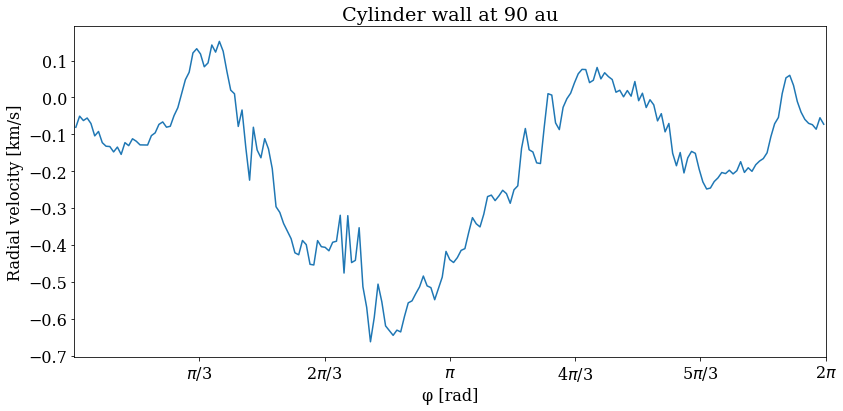

In [6]:
fig, axs = plt.subplots(figsize = (12,6))

axs.set_xticks(tick_values); axs.set_xticklabels(tick_labels)

axs.plot(phi_1Dbins, hist_velr_1D * data.cms_velocity * 1e-5)
axs.set(xlabel = 'φ [rad]', ylabel = 'Radial velocity [km/s]', xlim = (0, 2*np.pi), title = 'Cylinder wall at 90 au')
fig.tight_layout()

In [7]:
radius = 90
height = radius 
Nh = 100
N_phi = 200
G_cgs = G.to('cm**3 / (g * s**2)').value
radius /= data.au_length; height /= data.au_length
selection_radius = np.sqrt(radius**2 + height**2) * 2 
shell_Δ = 1; shell_Δ /= data.au_length

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

extracted_values =  {key: [] for key in range(7)} # So far this is only for densities and velocities

for p in tqdm.tqdm(sorted_patches):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = (p.cyl_R < radius - shell_Δ) & (p.cyl_R <  radius + shell_Δ)
    p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
    p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
    p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
    p.Br = np.sum(p.B * p.e_r, axis = 0)
    p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
    p.vr = np.sum(p.vrel * p.e_r, axis = 0)
    p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
    p.gradφ_r = np.sum(p.gradφ * p.e_r, axis = 0)
    
    
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 
    
    z_coor = p.cyl_z[to_extract].T 
    φ_coor = p.φ[to_extract].T
    vel_φr = p.vr[to_extract].T * p.vφ[to_extract].T
    B_φr =  p.Br[to_extract].T * p.Bφ[to_extract].T
    mass_val = p.m[to_extract].T 
    gradφ_φr = p.gradφ_r[to_extract].T * p.gradφ_φ[to_extract].T
       
    extracted_values[0].extend(z_coor.tolist())
    extracted_values[1].extend(φ_coor.tolist())
    extracted_values[2].extend(vel_φr.tolist())
    extracted_values[3].extend(mass_val.tolist())
    extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
    extracted_values[5].extend(B_φr.tolist())
    extracted_values[6].extend(gradφ_φr.tolist())

for key in extracted_values:
    extracted_values[key] = np.array(extracted_values[key])

#Making grid in height and phi direction:
z_grid = np.linspace(-height, height, Nh); phi_grid = np.linspace(0, 2 * np.pi, N_phi)

#Binning values
hist_mass, binedges_phi, binedges_z = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[3])
hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[4])
hist_vφvr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
hist_BφBr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass 
hist_gradφ_φr =np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass 

hist_ρ = hist_mass/hist_vol
reynolds_radial = - hist_vφvr * hist_ρ * data.cms_velocity**2 * data.cgs_density
maxwell_radial = hist_BφBr / (4 * np.pi) * data.sn.scaling.b**2
grav_radial = hist_gradφ_φr / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2

z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)
phi_bins = phi_grid[:-1] + 0.5 * np.diff(binedges_phi)

  8%|▊         | 108/1376 [00:00<00:02, 524.02it/s]

100%|██████████| 1376/1376 [00:02<00:00, 681.42it/s]


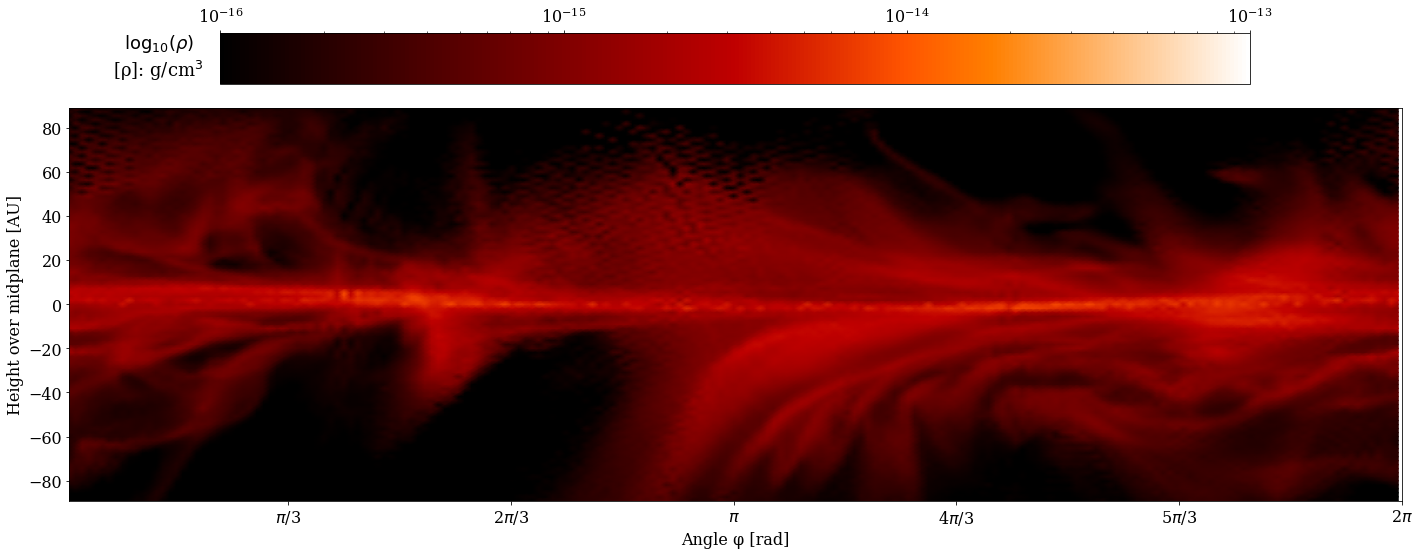

In [8]:
fig, axs = plt.subplots(figsize = (20,8))
cs = axs.pcolormesh(phi_bins, z_bins * data.au_length, (hist_ρ * data.cgs_density).T, norm = colors.LogNorm(vmin = 1e-16, vmax = 1e-13), snap = True, shading = 'gouraud', cmap = 'gist_heat')
cbar = fig.colorbar(cs, location = 'top', fraction = 0.11, ax = axs, );

cbar.set_label('$\log_{10}(ρ)$\n[ρ]: g/cm$^3$', labelpad = -70, x = -0.06, rotation = 0, fontsize = 18)
axs.set(ylabel = 'Height over midplane [AU]', xlabel = 'Angle φ [rad]')
axs.set_xticks(tick_values); axs.set_xticklabels(tick_labels);
fig.tight_layout()

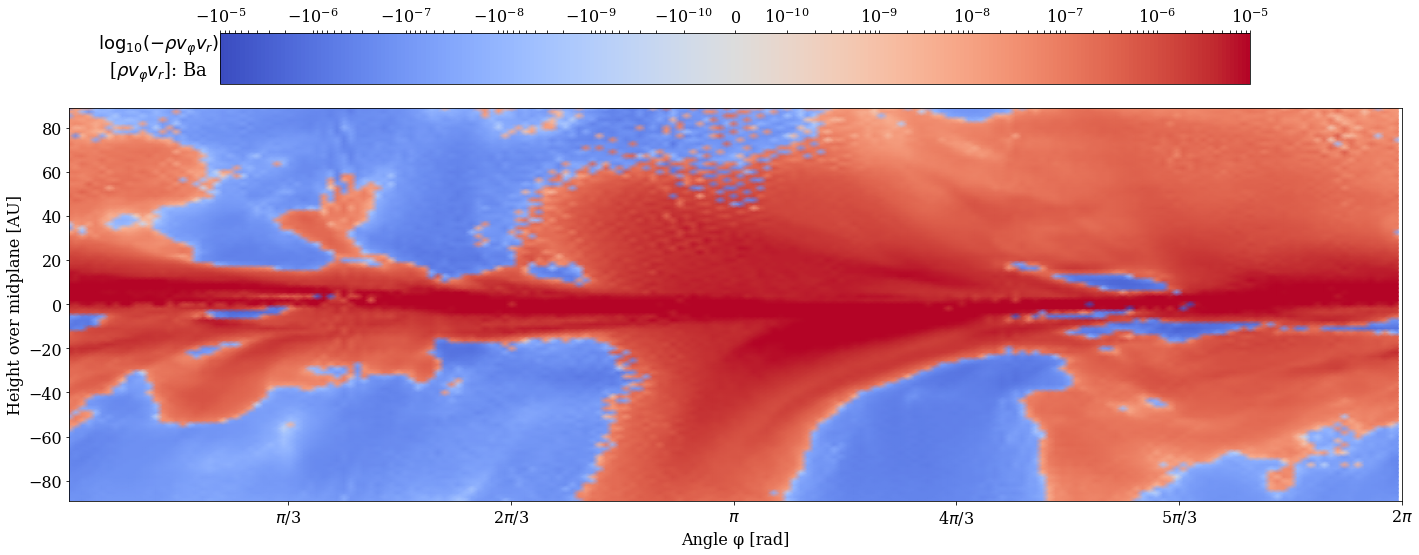

In [9]:
fig, axs = plt.subplots(figsize = (20,8))
cs = axs.pcolormesh(phi_bins, z_bins * data.au_length, reynolds_radial.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
cbar = fig.colorbar(cs, location = 'top', fraction = 0.11, ax = axs, );

cbar.set_label('$\log_{10}(-ρ v_φ v_r)$\n[$ρ v_φ v_r$]: Ba', labelpad = -70, x = -0.06, rotation = 0, fontsize = 18)
axs.set(ylabel = 'Height over midplane [AU]', xlabel = 'Angle φ [rad]')
axs.set_xticks(tick_values); axs.set_xticklabels(tick_labels);
fig.tight_layout()

In [10]:
np.nanmin(maxwell_radial), np.nanmax(maxwell_radial)

(-0.0018542112859866115, 0.00130092554683373)

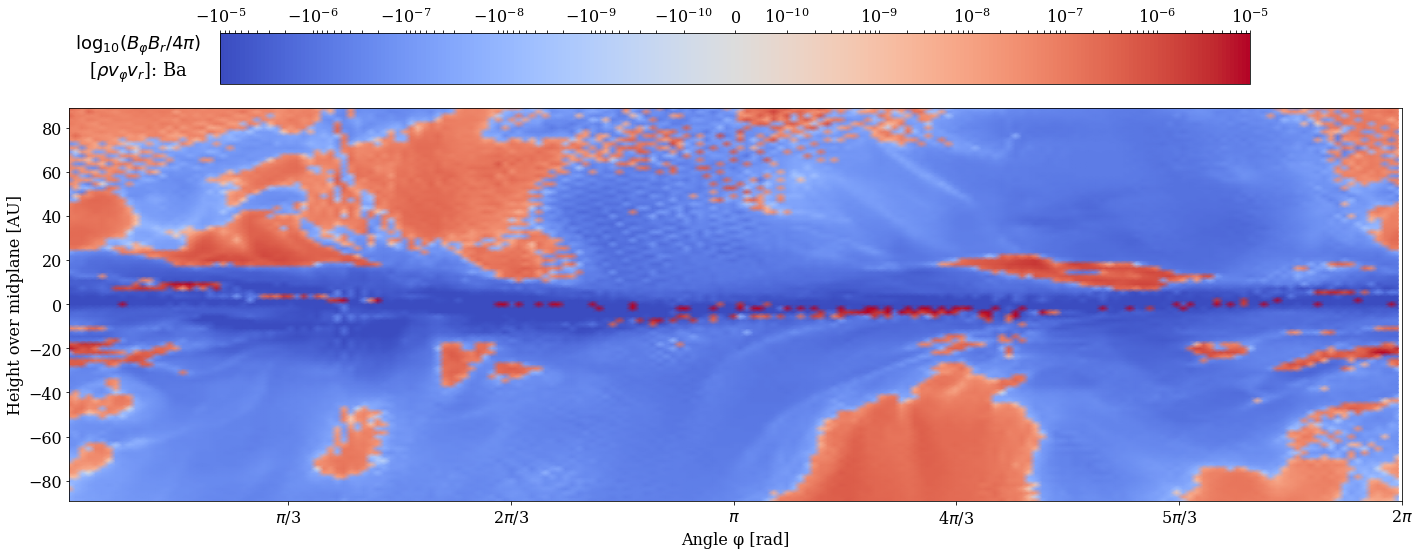

In [11]:
fig, axs = plt.subplots(figsize = (20,8))
cs = axs.pcolormesh(phi_bins, z_bins * data.au_length, maxwell_radial.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
cbar = fig.colorbar(cs, location = 'top', fraction = 0.11, ax = axs, );

cbar.set_label('$\log_{10}(B_φB_r/4π)$\n[$ρ v_φ v_r$]: Ba', labelpad = -70, x = -0.08, rotation = 0, fontsize = 18)
axs.set(ylabel = 'Height over midplane [AU]', xlabel = 'Angle φ [rad]')
axs.set_xticks(tick_values); axs.set_xticklabels(tick_labels);
fig.tight_layout()

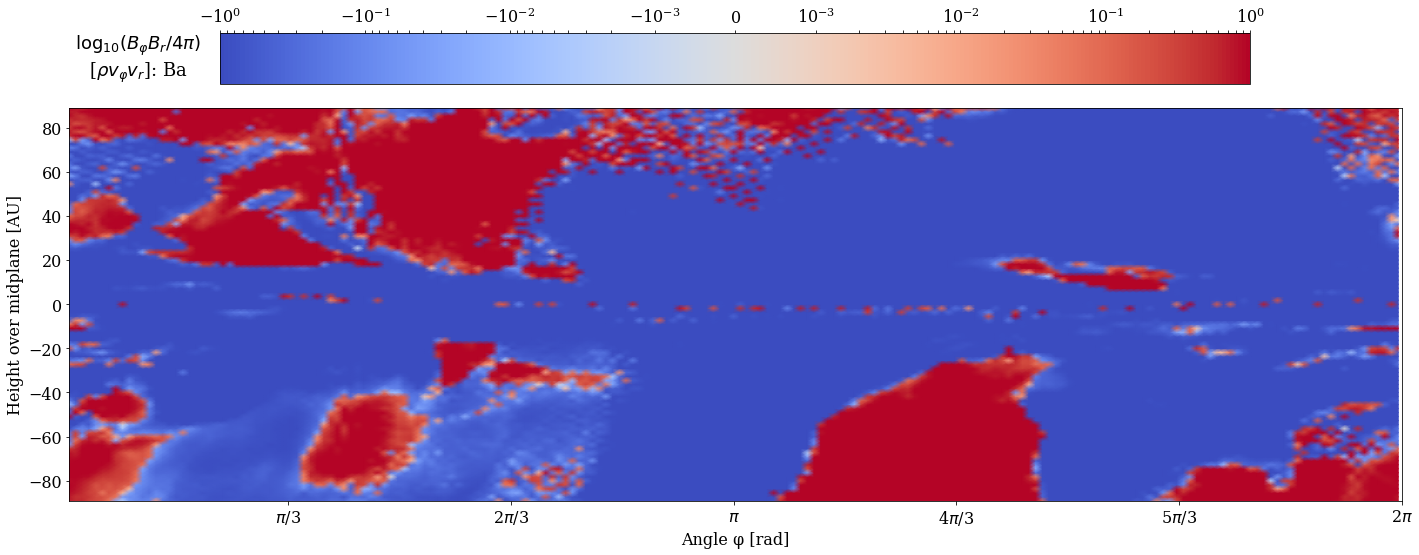

In [12]:
fig, axs = plt.subplots(figsize = (20,8))
cs = axs.pcolormesh(phi_bins, z_bins * data.au_length, (maxwell_radial.T - reynolds_radial.T) / (abs(maxwell_radial.T) + abs(reynolds_radial.T)), 
                    norm = colors.SymLogNorm(linthresh=1e-3, linscale=0.5, vmin = -1, vmax = 1), snap = True, shading = 'gouraud', cmap = 'coolwarm')
cbar = fig.colorbar(cs, location = 'top', fraction = 0.11, ax = axs, );

cbar.set_label('$\log_{10}(B_φB_r/4π)$\n[$ρ v_φ v_r$]: Ba', labelpad = -70, x = -0.08, rotation = 0, fontsize = 18)
axs.set(ylabel = 'Height over midplane [AU]', xlabel = 'Angle φ [rad]')
axs.set_xticks(tick_values); axs.set_xticklabels(tick_labels);
fig.tight_layout()

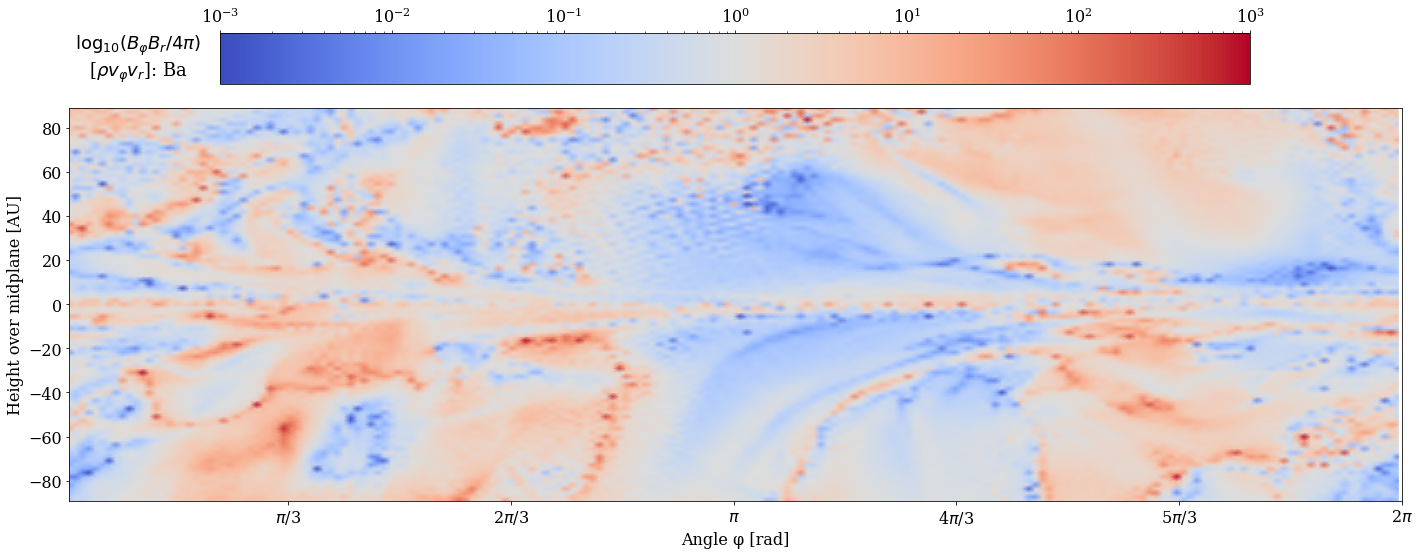

In [13]:
fig, axs = plt.subplots(figsize = (20,8))
cs = axs.pcolormesh(phi_bins, z_bins * data.au_length, abs(maxwell_radial.T)/abs(reynolds_radial.T), 
                    norm = colors.LogNorm(vmin = 1e-3, vmax = 1e3), snap = True, shading = 'gouraud', cmap = 'coolwarm')
cbar = fig.colorbar(cs, location = 'top', fraction = 0.11, ax = axs, );

cbar.set_label('$\log_{10}(B_φB_r/4π)$\n[$ρ v_φ v_r$]: Ba', labelpad = -70, x = -0.08, rotation = 0, fontsize = 18)
axs.set(ylabel = 'Height over midplane [AU]', xlabel = 'Angle φ [rad]')
axs.set_xticks(tick_values); axs.set_xticklabels(tick_labels);
fig.tight_layout()

In [14]:
np.nanmin(grav_radial), np.nanmax(grav_radial)

(-6.867059668109001e-07, 1.4974964174703615e-06)

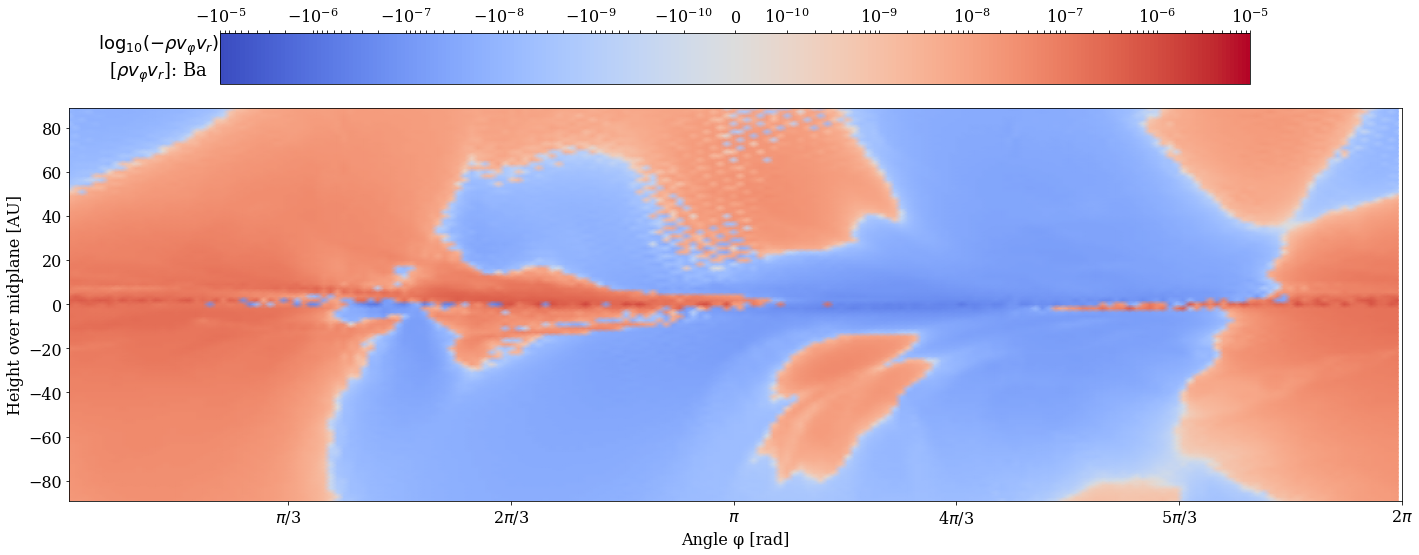

In [15]:
fig, axs = plt.subplots(figsize = (20,8))
cs = axs.pcolormesh(phi_bins, z_bins * data.au_length, grav_radial.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
cbar = fig.colorbar(cs, location = 'top', fraction = 0.11, ax = axs, );

cbar.set_label('$\log_{10}(-ρ v_φ v_r)$\n[$ρ v_φ v_r$]: Ba', labelpad = -70, x = -0.06, rotation = 0, fontsize = 18)
axs.set(ylabel = 'Height over midplane [AU]', xlabel = 'Angle φ [rad]')
axs.set_xticks(tick_values); axs.set_xticklabels(tick_labels);
fig.tight_layout()

In [16]:
stress_names = ['Reynolds', 'Maxwells', 'Grav. instability', 'Total']

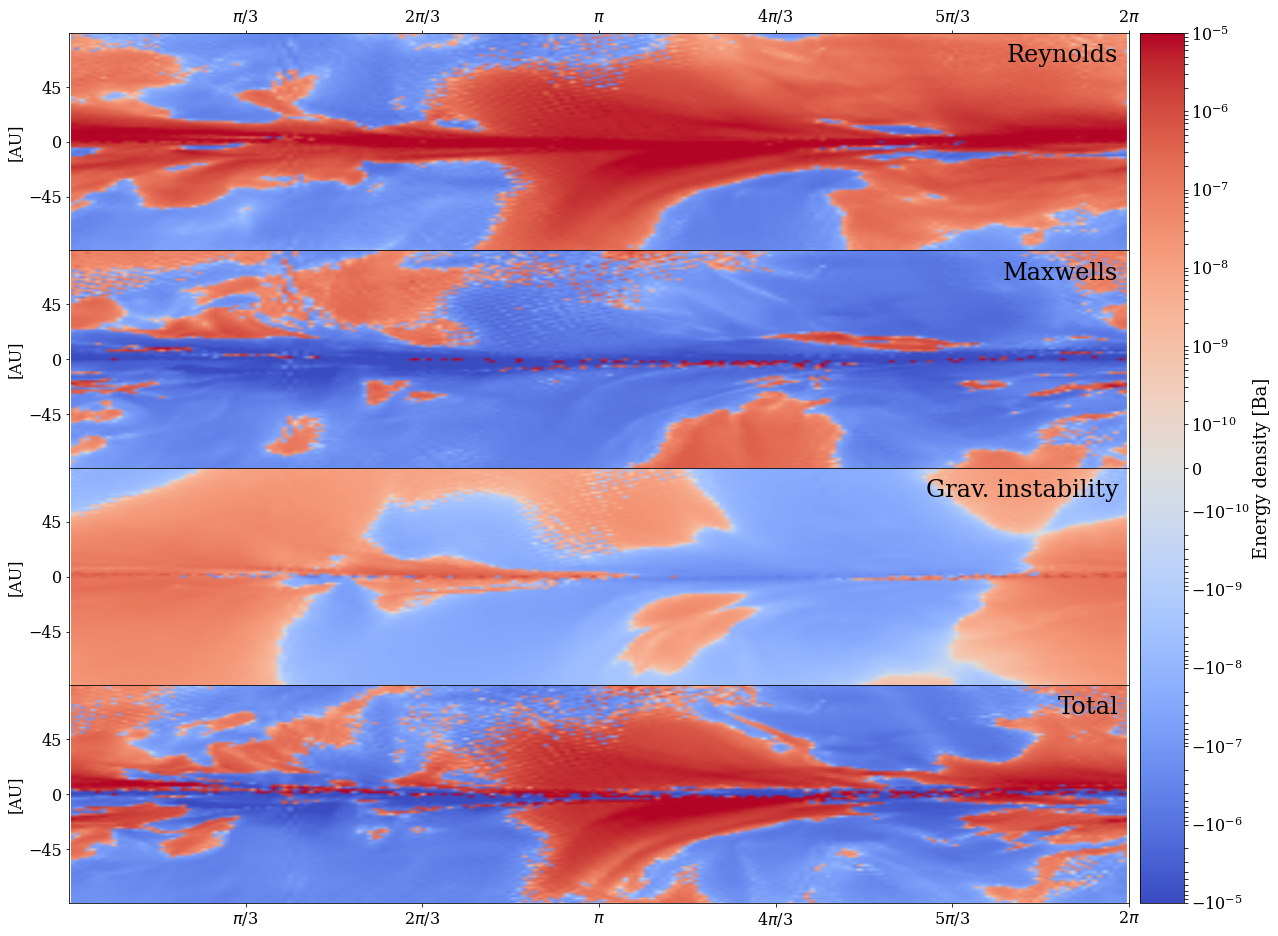

In [17]:
fig, axs = plt.subplots(4,1, figsize = (20,16))
for ax in axs.flatten():
    ax.set(ylabel = '[AU]', xlim = (0, 2*np.pi))

ax = axs[0]
ax.set_xticks(tick_values); ax.set_xticklabels(tick_labels); ax.xaxis.tick_top()

for ax in axs.flatten()[1:3]:
    ax.set_xticklabels([])
    
total_stress_R = reynolds_radial + maxwell_radial + grav_radial
ax = axs[-1]
ax.set_xticks(tick_values); ax.set_xticklabels(tick_labels);
ax.pcolormesh(phi_bins, z_bins * data.au_length, total_stress_R.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
ax.set_yticks([-45,0, 45])
ax.text(0.99, 0.95, 'Total', transform=ax.transAxes, ha='right', va='top', fontsize = 24)


for ax, stress, name in zip(axs.flatten(), [reynolds_radial, maxwell_radial, grav_radial], stress_names):
    cs = ax.pcolormesh(phi_bins, z_bins * data.au_length, stress.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
    ax.set_yticks([-45,0, 45])
    ax.text(0.99, 0.95, name, transform=ax.transAxes, ha='right', va='top', fontsize = 24)


fig.subplots_adjust(wspace=0, hspace=0)
cbar = fig.colorbar(cs, ax=axs.ravel().tolist(), fraction = 0.04, pad = 0.01)
cbar.set_label('Energy density [Ba]',fontsize = 18)



# Now for the vertical part

# Calculating the all the differnt component of anguluar momentum loss in the vertical direction

### Mechanical (Raynolds stress):
#### $$F_v^{Reynolds}(R)=\mp\int_{0}^{R}dr \int_0^{2\pi}r^2d\phi \rho v_\phi(r,\phi,\pm h/2)v_z(r,\phi,\pm h/2)$$

### Magnetically induced transport (Maxwell stress)
#### $$F_v^{Maxwell}(R)=\pm\int_{0}^{R}dr \int_0^{2\pi}r^2d\phi \frac{B_\phi(r,\phi,\pm h/2)B_z(r,\phi,\pm h/2)}{4\pi}$$

### Transport associated with the gravitational potential $\nabla\Phi^2$ (transport through spiral arms and similar nonaxisymmetric structures)
#### $$F_v^{Grav.}(R)=\mp\int_{0}^{R}dr \int_0^{2\pi}r^2d\phi \frac{(\nabla\Phi)_\phi(r,\phi,\pm h/2)(\nabla\Phi)_z(r,\phi,\pm h/2)}{4\pi G}$$

In [18]:
radius = 90
height = radius
Nr = 300
N_phi = 200
G_cgs = G.to('cm**3 / (g * s**2)').value
radius /= data.au_length; height /= data.au_length
selection_radius = np.sqrt(radius**2 + height**2) * 2 
shell_Δ = 1; shell_Δ /= data.au_length

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

extracted_values =  {key: [] for key in range(7)} # So far this is only for densities and velocities

for p in tqdm.tqdm(sorted_patches):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = (abs(p.cyl_z) > height - shell_Δ) & (abs(p.cyl_z) <  height + shell_Δ)
    p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
    p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
    p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
    p.Bz = np.sum(p.B * data.L[:,None, None, None], axis = 0)
    p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
    p.vz = np.sum(p.vrel * data.L[:,None, None, None], axis = 0)
    p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
    p.gradφ_z = np.sum(p.gradφ * data.L[:,None, None, None], axis = 0)
    
    
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 
    
    r_coor = p.cyl_R[to_extract].T 
    φ_coor = p.φ[to_extract].T
    vel_φz = p.vz[to_extract].T * p.vφ[to_extract].T
    B_φz =  p.Bz[to_extract].T * p.Bφ[to_extract].T
    mass_val = p.m[to_extract].T 
    gradφ_φz = p.gradφ_r[to_extract].T * p.gradφ_z[to_extract].T
       
    extracted_values[0].extend(r_coor.tolist())
    extracted_values[1].extend(φ_coor.tolist())
    extracted_values[2].extend(vel_φz.tolist())
    extracted_values[3].extend(mass_val.tolist())
    extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
    extracted_values[5].extend(B_φz.tolist())
    extracted_values[6].extend(gradφ_φz.tolist())

for key in extracted_values:
    extracted_values[key] = np.array(extracted_values[key])

#Making grid in height and phi direction:
r_grid = np.logspace(np.log10(1e-3 / data.au_length), np.log10(radius), Nr); phi_grid = np.linspace(0, 2 * np.pi, N_phi)

#Binning values
hist_mass, binedges_phi, binedges_r = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[3])
hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[4])
hist_vφvz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
hist_BφBz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass 
hist_gradφ_φz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass 

hist_ρ = hist_mass/hist_vol
reynolds_vertical = - hist_vφvz * hist_ρ * data.cms_velocity**2 * data.cgs_density
maxwell_vertical = hist_BφBz / (4 * np.pi) * data.sn.scaling.b**2
grav_vertical = hist_gradφ_φz / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2

r_bins = r_grid[:-1] + 0.5 * np.diff(binedges_r)
phi_bins = phi_grid[:-1] + 0.5 * np.diff(binedges_phi)

 16%|█▌        | 215/1376 [00:00<00:01, 1073.33it/s]

100%|██████████| 1376/1376 [00:01<00:00, 1033.85it/s]
/tmp/ipykernel_422236/1695463432.py:62: RuntimeWarning: invalid value encountered in true_divide
  hist_vφvz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_422236/1695463432.py:63: RuntimeWarning: invalid value encountered in true_divide
  hist_BφBz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_422236/1695463432.py:64: RuntimeWarning: invalid value encountered in true_divide
  hist_gradφ_φz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_422236/1695463432.py:66: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = hist_mass/hist_vol


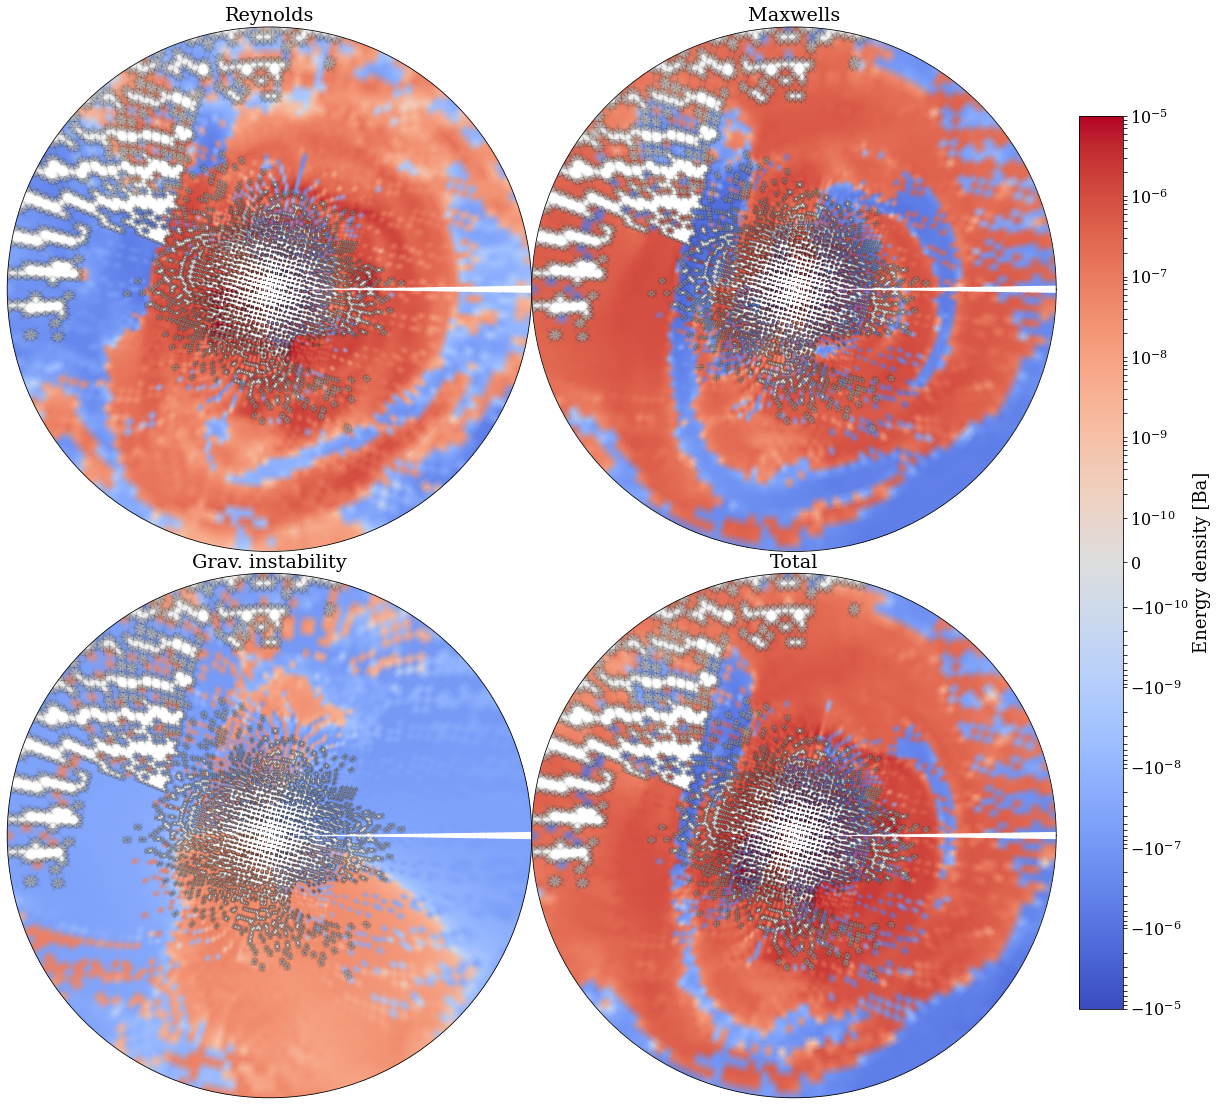

In [19]:
fig, axs = plt.subplots(2,2, figsize = (20,20), subplot_kw={'projection' :'polar'})

for ax in axs.flatten():
    ax.set_xticks([]); ax.set_xticklabels([])
    ax.set_yticks([])
    
total_stress_V = reynolds_vertical + maxwell_vertical + grav_vertical
ax = axs.flatten()[-1]
ax.set_xticks([]); ax.set_xticklabels([]);
ax.pcolormesh(phi_bins, r_bins * data.au_length, total_stress_V.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
ax.set(title = 'Total')

for ax, stress, name in zip(axs.flatten(), [reynolds_vertical, maxwell_vertical, grav_vertical], stress_names):
    cs = ax.pcolormesh(phi_bins, r_bins * data.au_length, stress.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
    ax.set(title = name)
    #ax.text(0.99, 0.95, name, transform=ax.transAxes, ha='right', va='top', fontsize = 24)


fig.subplots_adjust(wspace=0, hspace=0.01)
cbar = fig.colorbar(cs, ax=axs.ravel().tolist(), fraction = 0.04, pad = 0.02)
cbar.set_label('Energy density [Ba]',fontsize = 18)



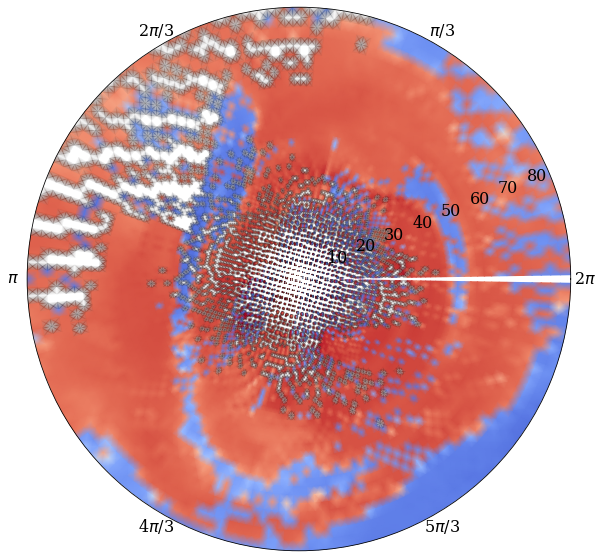

In [20]:
fig, axs = plt.subplots(figsize = (10,10), subplot_kw={'projection' :'polar'})
axs.pcolormesh(phi_bins, r_bins * data.au_length, total_stress_V.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
axs.set_xticks(tick_values);
axs.set_xticklabels(tick_labels);